In [51]:
import openai
from openai import OpenAI
import torch
import pymupdf
import pdfplumber
from PIL import Image
import io
import pytesseract
import pandas as pd
import camelot
import faiss
import clip
import numpy as np
from transformers import GPT2Tokenizer
from sklearn.decomposition import PCA
import requests
from bs4 import BeautifulSoup
import base64
import requests
from io import BytesIO
import os
import boto3
from dotenv import load_dotenv
from PIL import ExifTags
import piexif

In [53]:
text_archive = []
image_archive = []
text_metadata = []
image_metadata = []

def get_text_embedding(text):
    response = openai.embeddings.create(input=text, model="text-embedding-3-small")
    return response

# def get_text_embedding(text):
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     model, _ = clip.load("ViT-B/32", device=device)
#     text_preprocessed = clip.tokenize([text]).to(device)
#     with torch.no_grad():
#         text_features = model.encode_text(text_preprocessed)
#     return text_features.cpu().numpy()

def get_image_embedding(image):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    img_preprocessed = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(img_preprocessed)
    return image_features.cpu().numpy()

    return image_embedding

In [54]:
def chunk_text(text, max_tokens=300, overlap_tokens=50):
    from transformers import GPT2Tokenizer

    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    sentences = text.split('.')
    current_chunk = []
    current_length = 0
    chunks = []

    for sentence in sentences:
        tokens = tokenizer.encode(sentence, add_special_tokens=False)
        token_length = len(tokens)

        # If adding this sentence exceeds the max_tokens, save the current chunk
        if current_length + token_length > max_tokens:
            chunks.append('.'.join(current_chunk) + '.')

            # Start a new chunk with overlap
            if overlap_tokens > 0:
                overlap_sentence_count = 0
                overlap_chunk = []
                for overlap_sentence in reversed(current_chunk):
                    overlap_chunk.append(overlap_sentence)
                    overlap_sentence_count += len(tokenizer.encode(overlap_sentence, add_special_tokens=False))
                    if overlap_sentence_count >= overlap_tokens:
                        break
                current_chunk = list(reversed(overlap_chunk))
                current_length = sum(len(tokenizer.encode(s, add_special_tokens=False)) for s in current_chunk)
            else:
                current_chunk = []
                current_length = 0

        current_chunk.append(sentence)
        current_length += token_length

    # Add the last chunk
    if current_chunk:
        chunks.append('.'.join(current_chunk) + '.')

    return chunks

def clean_text(text):
    cleaned_text = text.replace('\n', ' ').replace('\r', '')
    cleaned_text = ' '.join(cleaned_text.split())  # Remove excessive spaces
    return cleaned_text

In [55]:
def ocr_images(images):
    ocr_texts = []
    for image in images:
        ocr_text = pytesseract.image_to_string(image)
        cleaned_ocr_text = clean_text(ocr_text)
        chunked_ocr_texts = chunk_text(cleaned_ocr_text)
        ocr_texts = chunked_ocr_texts
    
    return ocr_texts

In [56]:
# Function to extract text, images, and tables from a PDF and clean the extracted text
def extract_pdf_content(pdf_path):
    doc = pymupdf.open(pdf_path)
    text_chunks = []
    textMetadata = []
    images = []
    imageMetadata = []
    tables = []
    
    file_name = pdf_path.replace('.pdf', '').replace('Data/', '')

    # Process each page using PyMuPDF and pdfplumber
    with pdfplumber.open(pdf_path) as pdf:
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            plumber_page = pdf.pages[page_num]

            # Extract text
            text = page.get_text()
            if text:
                cleaned_text = clean_text(text)
                chunks = chunk_text(cleaned_text)
                text_chunks.extend(chunks)
                for chunk in chunks:
                    metadata = {
                        "file": file_name,
                        "page_number": page_num + 1,  # 1-based index
                        "chunk_length": len(chunk)
                    }
                    textMetadata.append(metadata)

            # Extract images
            for img_index, img in enumerate(page.get_images(full=True)):
                xref = img[0]
                base_image = doc.extract_image(xref)
                image_bytes = base_image["image"]
                image_ext = base_image["ext"]
                image = Image.open(io.BytesIO(image_bytes))
                images.append(image)
                metadata = {
                    "file": file_name,
                    "page_number": page_num + 1,  # 1-based index
                    "image_index": img_index,
                    "image_extension": image_ext,
                    "image_size": image.size  # (width, height)
                }
                imageMetadata.append(metadata)

#             # Extract tables
#             table = plumber_page.extract_table()
#             if table:
#                 tables.append(pd.DataFrame(table))
    
    # Extract text from images using OCR (optional)
    ocr_texts = ocr_images(images)
    for ocr_text in ocr_texts:
        metadata = {
            "file": file_name,
            "page_number": page_num + 1,  # 1-based index
            "chunk_length": len(chunk)
                    }
        text_chunks.append(ocr_text)
        textMetadata.append(metadata)
    
    return {
        "text_chunks": text_chunks,
        "images": images,
#         "tables": tables,
        "text_metadata": textMetadata,
        "image_metadata": imageMetadata
    }

In [57]:
def extract_webpage_content(url):
    text_chunks = []
    text_metadata = []
    images = []
    image_metadata = []
    
    # Fetch and parse the web page
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Extract and process text content
    text_content = ' '.join([p.get_text() for p in soup.find_all(['p', 'h1', 'h2', 'h3'])]).strip()
    if text_content:
        # Assume you have defined the clean_text and chunk_text functions
        cleaned_text = clean_text(text_content)
        chunks = chunk_text(cleaned_text)
        text_chunks.extend(chunks)
        
        # Collect text metadata
        for chunk in chunks:
            metadata = {
                "file": url.replace('https://', '').replace('http://', '').split('/')[0],  # Use domain as file name
                "page_number": None,
                "chunk_length": len(chunk)
            }
            text_metadata.append(metadata)

    # Extract and process images
    image_urls = [img['src'] for img in soup.find_all('img')]
    for img_index, img_url in enumerate(image_urls):
        try:
            # Handle relative URLs
            if not img_url.startswith('http'):
                img_url = requests.compat.urljoin(url, img_url)

            img_response = requests.get(img_url)
            image = Image.open(io.BytesIO(img_response.content))
            images.append(image)

            # Collect image metadata
            metadata = {
                "file": url.replace('https://', '').replace('http://', '').split('/')[0],  # Use domain as file name
                "page_number": None,
                "image_index": img_index,
                "image_extension": img_url,
                "image_size": image.size  # (width, height)
            }
            image_metadata.append(metadata)

        except Exception as e:
            print(f"Error processing image {img_url}: {e}")

    return {
        "text_chunks": text_chunks,
        "text_metadata": text_metadata,
        "images": images,
        "image_metadata": image_metadata
    }

In [58]:
pdfs = [
    {"path": "Data/OperationalManagementPlan.pdf", "name": "Justice Robert Hope Park Operational Management Plan - ACT government"},
    {"path": "Data/BoxGumGrassyWoodlandNationalRecoveryPlan.pdf", "name": "Box Gum Grassy Woodland National Recovery Plan"},
    {"path": "Data/EnvironmentalOffsets.pdf", "name": "ACT Government Environmental Offsets Mapping"},
    {"path": "Data/NatureConservationAct.pdf", "name": "ACT Government Nature Conservation Act"},
    {"path": "Data/ReserveManagementPlan.pdf", "name": "Canberra Nature Park Reserve Management Plan"},
    {"path": "Data/StateOfEnvironment.pdf", "name": "ACT State of the Environment Report"},
    {"path": "Data/WoodlandConservationStrategy.pdf", "name": "ACT Native Woodland Conservation Strategy"},
    {"path": "Data/WoodlandConservationStrategyBoxGumGrassyWoodland.pdf", "name": "ACT Woodland Conservation Strategy (Box Gum Grassy Woodland)"},
    {"path": "Data/WatsonWoodlandsWorkingGroup.pdf", "name": "History of the Watson Woodlands Working Group"},
    {"path": "Data/DAComment.pdf", "name": "Conservation Council Comment on Residential Development Application"}
]

webpages = [
    {"url": "https://www.parks.act.gov.au/find-a-park/canberra-nature-park/justice-robert-hope-park", "name": "ACT Government Website - Justice Robert Hope Park"},
    {"url": "https://www.environment.act.gov.au/ACT-parks-conservation/environmental-offsets/individual-projects/justice-robert-hope-park-offset-area", "name": "ACT Government Website - Justice Robert Hope Park Biodiversity Offset Area"},
    {"url": "https://greens.org.au/act/news/act-greens-act-protect-act-endangered-woodlands-development-0", "name": "ACT Greens News report - ACT Greens Protect Endangered Woodlands from Development"},
    {"url": "https://citynews.com.au/2014/volunteers-feel-duped-land-greed/", "name": "City News - Watson Woodlands Working Group Feel Duped by Land Greed after Development Application"},
    {"url": "https://www.northcanberra.org.au/watson-community-association-celebrates-10th-anniversary-of-justice-robert-hope-park/", "name": "Watson Community Association Celebrates 10th Anniversary of Justice Robert Hope Park"},
    {"url": "https://archive.md/edKBa", "name": "Sydney Morning Herald - Woodlands defenders welcome 'inadequate' nature reserve in Watson"}
]

for pdf in pdfs:
    extracted_content = extract_pdf_content(pdf["path"])
    document_name = pdf["name"]
#     image_archive.extend(extracted_content['images'])
#     image_metadata.extend(extracted_content['image_metadata'])
    for chunk in extracted_content['text_chunks']:
        text_archive.append(f"The following text is an excerpt from the document {document_name}. {chunk} ")
    text_metadata.extend(extracted_content['text_metadata'])
    
for webpage in webpages:
    extracted_content = extract_webpage_content(webpage["url"])
    document_name = webpage["name"]
#     image_archive.extend(extracted_content['images'])
#     image_metadata.extend(extracted_content['image_metadata'])
    for chunk in extracted_content['text_chunks']:
        text_archive.append(f"{chunk} This text is an excerpt from the webpage {document_name}.")
    text_metadata.extend(extracted_content['text_metadata'])

Error processing image https://www.facebook.com/tr?id=2430313267242960&ev=PageView&noscript=1: cannot identify image file <_io.BytesIO object at 0x33423e390>
Error processing image https://www.facebook.com/tr?id=218184722269912&ev=PageView&noscript=1: cannot identify image file <_io.BytesIO object at 0x33d9ad170>


In [63]:
reviews = (
    "The following are reviews from visitors to the park.\n\n"
    "Review: 5 stars. No barbed wire, which makes it very different to most of Canberra Nature Park.\n"
    "Review: 5 stars. Very peaceful a magpie greeted me and saw/heard kookaburras laughing nearby. Beautiful spot.\n"
    "Review: 5 stars. Short walk, probably 2K return, in circuit. Perfect for family.\n"
    "Review: 5 stars. A hidden gem in Watson. Bring your family and have some mask free time without being judged by others on their walk! But please, please, please keep the gates closed when you come and go into this area. And keep your dog in a leash!\n"
    "Review: 4 stars. Love walking the dog there...Haven't been there for a while...It was great to see it hadn't changed...was kept mowed and tidy when i was there few days ago....been there nearly every day...\n"
    "Review: 5 stars. Small nature park at the back of Watson. Paths mowed, easy walking\n"
    "Review: 5 stars. A great little slice of bushland with some rare old trees, leave it as you find it.\n"
    "Review: 4 stars. Pretty good walking track, dog off leash area.\n"
    "Review: 5 stars. Nice park of Dry Eucalypts. Came here when there was a Regent Honeyeater.\n"
    "Review: 3 stars. Pretty basic....great little wool shed\n"
    "Review: 5 stars. I like the eucalyptus trees in this park. My horse like the grass from the trees that are in park.\n"
    "Review: 5 stars. Probably the best natural area around Watson.\n"
    "Review: 5 stars. nice place to walk around"
)

with open("Data/abc_podcast_excerpt.txt", 'r') as file:
    # Read the content of the file
    podcast = file.read()

podcast = "The following is an excerpt from an ABC podcast episode titled 'The trouble with offsets', hosted by Di Martin: " + clean_text(podcast)

In [65]:
text_archive.append(reviews)
text_metadata.append({
    "file": "Reviews",
    "page_number": None,
    "chunk_length": len(reviews)
            })

text_archive.append(podcast)
text_metadata.append({
    "file": "Podcast",
    "page_number": None,
    "chunk_length": len(podcast)
})

In [67]:
## NEXT STEP - PROCESS ALA DATA

from dateutil import parser

ala_data = pd.read_csv('Data/ALA.csv')
ala_output = ala_data.apply(lambda row: f"The following is a citizen science observation of a sighting at Justice Robert Hope Park - "
                                        f"Species: {row['scientificName']} "
                                        f"Date: {parser.parse(row['eventDate'])} "
                                        f"Coordinates: {row['decimalLatitude']} {row['decimalLongitude']} "
                                        f"Comments: {row['eventRemarks'] if pd.notna(row['eventRemarks']) else 'No comments'} {row['occurrenceRemarks'] if pd.notna(row['occurrenceRemarks']) else 'No comments'}",
                            axis=1)

# Convert the output to a list
ala_output_list = ala_output.tolist()

# Print the list
print(ala_output_list)

['The following is a citizen science observation of a sighting at Justice Robert Hope Park - Species: Platycercus (Violania) eximius Date: 2014-05-18 00:00:00+00:00 Coordinates: -35.236327 149.164629 Comments: No comments No comments', 'The following is a citizen science observation of a sighting at Justice Robert Hope Park - Species: Ocyphaps lophotes Date: 2020-01-13 18:05:00+00:00 Coordinates: -35.236327 149.164629 Comments: unsuccessful search for the Regent.  Nice to see the other birders and birds though. No comments', 'The following is a citizen science observation of a sighting at Justice Robert Hope Park - Species: Platycercus (Violania) eximius Date: 2018-03-14 16:26:00+00:00 Coordinates: -35.236327 149.164629 Comments: No comments No comments', 'The following is a citizen science observation of a sighting at Justice Robert Hope Park - Species: Ocyphaps lophotes Date: 2020-01-17 08:52:00+00:00 Coordinates: -35.235891 149.166119 Comments: No comments No comments', 'The followi

In [68]:
for obs in ala_output_list:
    text_archive.append(obs)

In [69]:
top_species = """The following are the top 25 species observed by birdwatchers and citizen scientists at Justice Hope Park by count:
Manorina (Myzantha) melanocephala : 391
Gymnorhina tibicen : 387
Platycercus (Violania) eximius : 336
Platycercus (Platycercus) elegans : 328
Eolophus roseicapilla : 311
Cacatua (Cacatua) galerita : 308
Strepera (Strepera) graculina : 297
Corvus coronoides : 265
Grallina cyanoleuca : 248
Anthochaera (Anthochaera) carunculata : 247
Ocyphaps lophotes : 244
Acridotheres tristis : 221
Alisterus scapularis : 215
Sturnus (Sturnus) vulgaris : 209
Dacelo (Dacelo) novaeguineae : 201
Smicrornis brevirostris : 199
Trichoglossus : 192
Pardalotus (Pardalotinus) striatus : 149
Cracticus torquatus : 148
Chenonetta jubata : 132
Hirundo (Hirundo) neoxena : 130
Psephotus haematonotus : 113
Cacatua (Licmetis) sanguinea : 92
Corcorax melanorhamphos : 90
Pardalotus (Pardalotus) punctatus : 84"""

text_archive.append(top_species)

In [ ]:
## NEXT STEP - PROCESS WEATHER DATA

weather_data = pd.read_csv('Data/Weather.csv')

In [70]:
## NEXT STEP - PROCESS SATELLITE IMAGES

len(text_archive)

10232

In [10]:
## PROCESS IMAGE ARCHIVE

def encode_image(image):
    image = image.resize((300,300), Image.LANCZOS)
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    buffer.seek(0)
    encoded_string = base64.b64encode(buffer.read())
    return encoded_string.decode('utf-8')

def convert_image_to_rgb(image):
    if image.mode == 'RGBA':
        # Convert RGBA to RGB by removing the alpha channel
        background = Image.new("RGB", image.size, (255, 255, 255))
        background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
        return background
    elif image.mode == 'P':
        # Convert P (Palette) mode to RGB
        return image.convert("RGB")
    return image

def convert_all(image_objects):
    rgb_images = []
    for img in image_objects:
        rgb_img = convert_image_to_rgb(img)
        rgb_images.append(rgb_img)
    return rgb_images

In [71]:
bucket_name = 'jhp-ai-socy3001'
region_name = 'ap-southeast-2'
s3_client = boto3.client('s3', aws_access_key_id = AWS_ACCESS_KEY_ID, aws_secret_access_key = AWS_SECRET_ACCESS_KEY, region_name=region_name)

def upload_image_to_s3(image_path):
    with open(image_path, 'rb') as image_file:
        s3_client.upload_fileobj(image_file, bucket_name, os.path.basename(image_path))
        image_url = f'https://{bucket_name}.s3.{s3_client.meta.region_name}.amazonaws.com/{os.path.basename(image_path)}'
    return image_url

In [12]:
def get_metadata(image):
    codec = 'ISO-8859-1'  # or latin-1
    exif_dict = piexif.load(image.info.get('exif'))
    exif_tag_dict = {}
    thumbnail = exif_dict.pop('thumbnail', None)
    if thumbnail:
        exif_tag_dict['thumbnail'] = thumbnail.decode(codec)

    for ifd in exif_dict:
        exif_tag_dict[ifd] = {}
        for tag in exif_dict[ifd]:
            try:
                element = exif_dict[ifd][tag].decode(codec)
            except AttributeError:
                element = exif_dict[ifd][tag]
            exif_tag_dict[ifd][piexif.TAGS[ifd][tag]["name"]] = element

    datetime = exif_tag_dict['0th'].get('DateTime', None)
    gps = exif_tag_dict.get('GPS', {})

    def convert_to_degrees(value):
        """Convert GPS coordinates stored in EXIF to degrees in float."""
        if not value:
            return None
        degrees = value[0][0] / value[0][1]
        minutes = value[1][0] / value[1][1]
        seconds = value[2][0] / value[2][1]
        return degrees + (minutes / 60.0) + (seconds / 3600.0)

    def get_gps_coordinates(gps):
        """Convert EXIF GPS data to readable coordinates."""
        if gps:
            latitude = gps.get('GPSLatitude')
            longitude = gps.get('GPSLongitude')
            lat_ref = gps.get('GPSLatitudeRef', 'N')
            lon_ref = gps.get('GPSLongitudeRef', 'E')

            if latitude and longitude:
                lat = convert_to_degrees(latitude)
                lon = convert_to_degrees(longitude)
                if lat_ref == 'S':
                    lat = -lat
                if lon_ref == 'W':
                    lon = -lon
                return lat, lon
        return None, None

    latitude, longitude = get_gps_coordinates(gps)
    return datetime, latitude, longitude

In [13]:
client = OpenAI()

# Function to generate description using OpenAI API
def generate_description(image):
    rgb_image = convert_image_to_rgb(image)
    base64_image = encode_image(rgb_image)
    
    # Use OpenAI's API to generate a description
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user",
                    "content": [
                        {"type": "text", "text": "Describe this image in a sentence or two."},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
                    ]}
                 ]
    )
    
    return response.choices[0].message.content.strip()

In [ ]:
# Folder containing images
image_folder = 'Data/images'

# List to store image data
image_data = []

# Iterate through the images in the folder
for idx, filename in enumerate(os.listdir(image_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Load the image
        image_path = os.path.join(image_folder, filename)
        image_url = upload_image_to_s3(image_path)
        image = Image.open(image_path)

        # Generate description
        description = generate_description(image)
        date, lat, lon = get_metadata(image)
        embedding = get_text_embedding(description)

        # Append data to the list
        image_data.append([idx + 1, image_url, description, lat, lon, date])

# Convert the list to a NumPy array
# Note: NumPy does not directly support PIL images, so we'll store them as objects
images = pd.DataFrame(image_data, columns=['Index', 'ImageURL', 'Description', 'Latitude', 'Longitude', 'DateTime'])
images.to_csv('images.csv', index=False)

In [72]:
def delete_txt_files(bucket_name):
    # Initialize the S3 client

    # Initialize variables for pagination
    continuation_token = None
    while True:
        # List objects in the bucket
        list_params = {'Bucket': bucket_name}
        if continuation_token:
            list_params['ContinuationToken'] = continuation_token
        
        response = s3_client.list_objects_v2(**list_params)

        # Check if the bucket contains objects
        if 'Contents' in response:
            # Iterate through all objects in the current page
            for obj in response['Contents']:
                # Check if the file has a .txt extension
                if obj['Key'].endswith('.txt'):
#                     print(f"Deleting {obj['Key']}...")
                    s3_client.delete_object(Bucket=bucket_name, Key=obj['Key'])
        
        # Check if there are more objects to list
        if response.get('IsTruncated'):  # More pages of results
            continuation_token = response.get('NextContinuationToken')
        else:
            break

    print("All .txt files have been removed.")

In [73]:
# Call the function to delete .txt files
# delete_txt_files(bucket_name)

All .txt files have been removed.


In [74]:
text_archive = [text for text in text_archive if text]

In [76]:
# Initialize list to store URLs
urls = []
# s3_client = boto3.client('s3', aws_access_key_id = AWS_ACCESS_KEY_ID, aws_secret_access_key = AWS_SECRET_ACCESS_KEY, region_name=region_name)

# Upload each text as a .txt file to S3
for idx, text in enumerate(text_archive):
    file_name = f'text_{idx + 1}.txt'
    s3 = boto3.resource(
        's3',
        region_name=region_name,
        aws_access_key_id = AWS_ACCESS_KEY_ID,
        aws_secret_access_key = AWS_SECRET_ACCESS_KEY
    )
    s3.Object(bucket_name, file_name).put(Body=text)

    # Generate S3 URL
    s3_url = f'https://{bucket_name}.s3.{region_name}.amazonaws.com/{file_name}'
    urls.append([idx + 1, s3_url])

# Create DataFrame from list
texts = pd.DataFrame(urls, columns=['Index', 'URL'])

# Save DataFrame to CSV
csv_file_path = 'texts.csv'
texts.to_csv(csv_file_path, index=False)

In [77]:
# GET EMBEDDINGS
text_embeddings = [get_text_embedding(text).data[0].embedding for text in text_archive]

In [ ]:
image_embeddings = [get_text_embedding(description).data[0].embedding for description in images['Description']]

In [78]:
text_embeddings_database = np.array(text_embeddings)
text_dimension = text_embeddings_database.shape[1]
text_index = faiss.IndexFlatL2(text_dimension)
text_index.add(text_embeddings_database)
faiss.write_index(text_index, "textArchive.index")

In [ ]:
image_embeddings_database = np.array(image_embeddings)
image_dimension = image_embeddings_database.shape[1]
image_index = faiss.IndexFlatL2(image_dimension)
image_index.add(image_embeddings_database)
faiss.write_index(image_index, "imageArchive.index")

In [79]:
import matplotlib.pyplot as plt
query_1 = np.array([get_text_embedding("Tell me about the birds in the park").data[0].embedding], dtype=np.float32)
query_2 = np.array([get_text_embedding("How do you feel about biodiversity offsets").data[0].embedding], dtype=np.float32)
query_3 = np.array([get_text_embedding("What kind of things can I do in the park?").data[0].embedding], dtype=np.float32)
query_4 = np.array([get_text_embedding("Who is Justice Hope?").data[0].embedding], dtype=np.float32)
query_5 = np.array([get_text_embedding("Bleep bloop soup blop").data[0].embedding], dtype=np.float32)
query_6 = np.array([get_text_embedding("What do you think the future holds for the park?").data[0].embedding], dtype=np.float32)
query_7 = np.array([get_text_embedding("What kind of impact does residential development have on the park?").data[0].embedding], dtype=np.float32)
query_8 = np.array([get_text_embedding("Can dogs roam around the park?").data[0].embedding], dtype=np.float32)

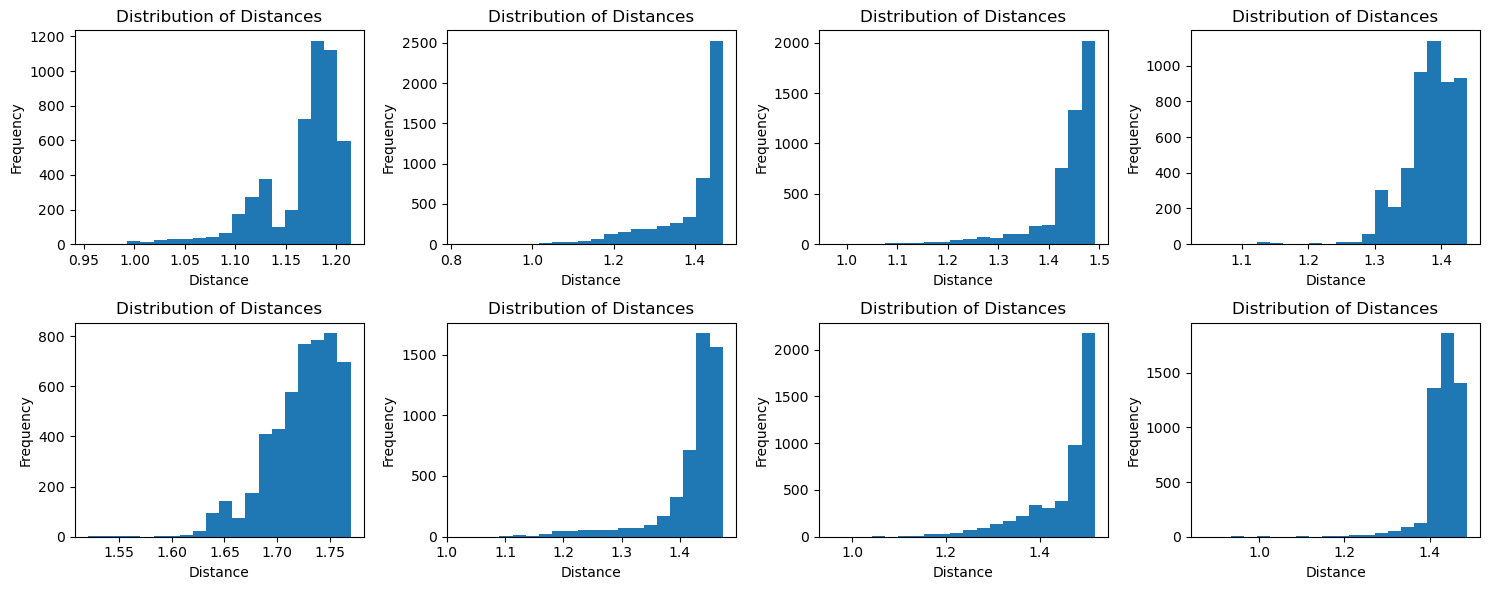

In [81]:
def plot_distance_distribution(query_embedding, index, num_samples=5000, ax=None):
    distances, indices = index.search(query_embedding, num_samples)
    if ax is None:
        ax = plt.gca()
    ax.hist(distances[0], bins=20)
    ax.set_xlabel('Distance')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Distances')

fig, axes = plt.subplots(2, 4, figsize=(15, 6))
axes = axes.flatten()

plot_distance_distribution(query_1, text_index, ax=axes[0])
plot_distance_distribution(query_2, text_index, ax=axes[1])
plot_distance_distribution(query_3, text_index, ax=axes[2])
plot_distance_distribution(query_4, text_index, ax=axes[3])
plot_distance_distribution(query_5, text_index, ax=axes[4])
plot_distance_distribution(query_6, text_index, ax=axes[5])
plot_distance_distribution(query_7, text_index, ax=axes[6])
plot_distance_distribution(query_8, text_index, ax=axes[7])

plt.tight_layout()
plt.show()
